In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'''\usepackage{amsmath}
          \usepackage{physics}
          \usepackage{siunitx}
          ''')
from matplotlib import ticker
from tqdm import tqdm

import scipy.constants as sc
from astropy.constants import codata2018 as ac
from astropy.constants import iau2015 as aa
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
import astropy.uncertainty as aun

from astropy.visualization import quantity_support
from matplotlib import cm


In [3]:
num = 100

density = np.logspace(25, 40, num=num) * u.m**-3
temperature = np.logspace(0, 12, num=num) * u.K

In [4]:
def fermi_momentum(d) -> u.kg * u.m / u.s:
    p_F = (3 * d / 8 / np.pi)**(1/3) * ac.h
    return(p_F)

def energy_from_momentum(p) -> u.J:
    e = ac.c * np.sqrt(p**2 + ac.m_e**2 * ac.c**2)
    return(e)

def fermi_energy(d):
    return(energy_from_momentum(fermi_momentum(d)))

In [5]:
pairs = np.meshgrid(density, temperature)

In [6]:
def quantify_degeneracy(d, T):
    T_F = (fermi_energy(d) - ac.m_e * ac.c**2) / ac.k_B
    # T_F = (fermi_energy(d)).to(u.K) 
    return (T / T_F)

In [7]:
from scipy.integrate import quad
m_e_dimensionless = (ac.m_e * ac.c**2).si.value
c_dimensionless = ac.c.si.value
def energy_from_momentum_dimensionless(p):
    return(np.sqrt((p * c_dimensionless)**2 + m_e_dimensionless**2))

@u.quantity_input
def quantify_relativisticity(d: u.m**-3, T: u.K) -> u.dimensionless_unscaled:
    p_F = fermi_momentum(d) 
    e_F = energy_from_momentum(p_F)
    T_momentum = 10 * T * ac.k_B / ac.c
    # ballparking the integration bounds
    max_p = (p_F + T_momentum).si.value
    # p_array = np.linspace(0, max_p, num=2000)
    E_F_dimensionless = e_F.si.value
    k_BT_dimensionless = (ac.k_B * T).si.value

    def integrand_ke(p_dimensionless):
        # p = p_dimensionless * u.kg * u.m / u.s
        # E = energy_from_momentum(p)
        E_dimensionless = energy_from_momentum_dimensionless(p_dimensionless)
        E_k = E_dimensionless - m_e_dimensionless
        distribution = 1/ (np.exp((E_dimensionless - E_F_dimensionless) / k_BT_dimensionless) + 1)
        # neglect normalization
        return ((p_dimensionless ** 2 * E_k  * distribution))

    def integrand_normalization(p_dimensionless):
        # p = p_dimensionless * u.kg * u.m / u.s
        # E = energy_from_momentum(p)
        E_dimensionless = energy_from_momentum_dimensionless(p_dimensionless)
        distribution = 1/ (np.exp((E_dimensionless - E_F_dimensionless) / k_BT_dimensionless) + 1)
        # neglect normalization
        return ((p_dimensionless ** 2  * distribution))

    energy_density = quad(integrand_ke, 0, max_p)[0]
    number_density = quad(integrand_normalization, 0, max_p)[0]
    average_energy = energy_density / number_density * u.J

    # relativisticity is quantified by the ratio of the 
    # average kinetic energy of an electron in the 
    # distribution to the electron rest energy

    return ((average_energy / (ac.m_e * ac.c**2)))

1.56 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
relativisticity = np.zeros((num, num))
degeneracy = np.zeros((num, num))

for i, d in tqdm(enumerate(density)):
    # print(d)
    for j, T in enumerate(temperature):
        relativisticity[j, i] = quantify_relativisticity(d, T)
        degeneracy[j, i] = quantify_degeneracy(d, T)

100it [05:07,  3.07s/it]


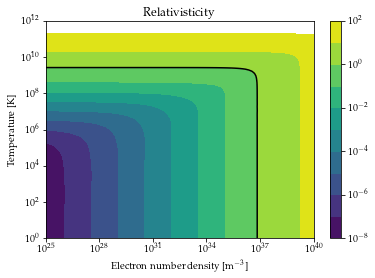

In [9]:
flat = relativisticity.flatten()
levels = 10**(np.arange(*np.round(np.log10([np.min(flat)+1e-40, np.max(flat)]))))

with quantity_support():
    c = plt.contourf(*pairs, relativisticity, levels=levels, locator=ticker.LogLocator())
    plt.contour(*pairs, relativisticity, levels=[1.], locator=ticker.LogLocator(), colors=('black',))
    plt.title('Relativisticity')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Electron number density [m$^{-3}$]')
    plt.ylabel('Temperature [K]')
    plt.colorbar(c)

In [29]:
quantify_relativisticity(1e26 * u.m**-3, 1e8 * u.K)
# fermi_energy(1e1 * u.m**-3).to(u.eV)

<Quantity 0.00803323>

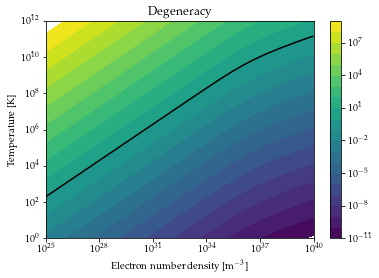

In [10]:
flat = degeneracy.flatten()
levels = 10**(np.arange(*np.round(np.log10([np.min(flat), np.max(flat)]))))

with quantity_support():
    c = plt.contourf(*pairs, degeneracy, levels=levels, locator=ticker.LogLocator())
    plt.contour(*pairs, degeneracy, levels=[1.], locator=ticker.LogLocator(), colors=('black',))
    plt.title('Degeneracy')
    plt.xlabel('Electron number density [m$^{-3}$]')
    plt.ylabel('Temperature [K]')
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar(c)

In [12]:
sun_core = (1.5e5 * u.kg / u.m**3 / ac.m_p, 1.56e7 * u.K)
iron_core = ((1e8 * u.g / u.cm**3 / ac.m_p / 2).si, 2.5e9 * u.K)
iron_room_temperature = ((10 * u.g / u.cm**3 / ac.m_p / 2).si, 300 * u.K)
white_dwarf = ((1e9 * u.kg / u.m**3 / ac.m_p).si, 1e7 * u.K)
iron_room_temperature

(<Quantity 2.9893187e+30 1 / m3>, <Quantity 300. K>)

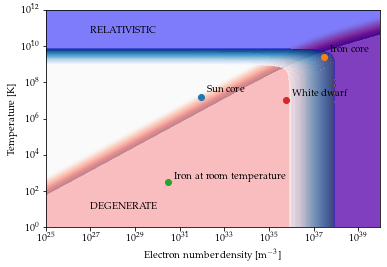

In [36]:
# levels_transition = np.append(np.logspace(-1, 1, num=10), np.inf)
levels_transition = np.logspace(-.5, .5)

def deviate(tuple):
    # move the annotation labels
    return (tuple[0]*1.8, tuple[1]*1.8)

with quantity_support():
    c1 = plt.contourf(*pairs, degeneracy, levels=levels_transition, label='Degeneracy boundary', alpha=.5, cmap = cm.get_cmap('Reds_r'), locator=ticker.LogLocator(), extend = 'both')
    c2 = plt.contourf(*pairs, relativisticity, levels=levels_transition, label='Relativisticity boundary', alpha=.5, cmap = cm.get_cmap('Blues'), locator=ticker.LogLocator(), extend = 'both')
    # c1.cmap.set_under('red')
    # c2.cmap.set_over('blue')

    plt.annotate('Sun core', deviate(sun_core))
    plt.annotate('Iron core', deviate(iron_core))
    plt.annotate('Iron at room temperature', deviate(iron_room_temperature))
    plt.annotate('White dwarf', deviate(white_dwarf))
    plt.scatter(*sun_core)
    plt.scatter(*iron_core)
    plt.scatter(*iron_room_temperature)
    plt.scatter(*white_dwarf)

    plt.annotate('DEGENERATE', (1e27/u.m**3, 1e1 * u.K))
    plt.annotate('RELATIVISTIC', (1e27/u.m**3, 5e10 * u.K))

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Electron number density [m$^{-3}$]')
    plt.ylabel('Temperature [K]')
    plt.savefig('relativisticity_degeneracy.pdf', transparent=True)


In [31]:
print(quantify_relativisticity(*iron_core))
print(quantify_degeneracy(*iron_core))
    

2.3062125401386084
0.148441310716941
